# EXPLORATION 10 : 뉴스 요약봇 만들기

## 준비한 데이터
- [뉴스 기사 데이터](https://github.com/sunnysai12345/News_Summary)

## 1. 데이터 수집하기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(10)

,headlines,text
64022,India U-17 keeper scores from behind goal line...,India's Under-17 goalkeeper Dheeraj Singh Moir...
53323,"32 missing after oil tanker, cargo ship collid...",As many as 32 people have been reported missin...
45128,Assam government extends AFSPA by six months,The Assam government has extended the Armed Fo...
46550,Video: Police in Egypt catch 5-yr-old falling ...,Egypt's Interior Ministry has released a video...
22291,ICICI Bank shares surge 8% after clarification...,ICICI Bank's shares surged as much as 8.6% on ...
93495,K'taka to spilt textbooks in half amid raw mat...,Amid a shortage of raw materials for printing ...
36238,Raze legal buildings posing safety risk: SC to...,The Supreme Court has directed a Special Task ...
71677,Indian shooter wins silver in double trap at W...,Indian shooter Ankur Mittal won a silver medal...
70686,Post-flight alcoholic test endangers lives: Ai...,Air India pilots' union Indian Commercial Pilo...
39718,Rohtak man claims his wife was killed by her f...,"In an alleged case of honour killing, a 24-yea..."


test가 본문, headline이 요약본

In [3]:
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98401


In [4]:
print(data.loc[0]['headlines'])
print(data.loc[0]['text'])

upGrad learner switches to career in ML & Al with 90% salary hike
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.


## 2. 데이터 전처리하기

### 중복값 , 결측치 제거

In [5]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플 수 :',(len(data)))

전체 샘플 수 : 98360


In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 텍스트 정규화, 불용어 제거

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

정규화 사전의 수:  120
불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', '

In [9]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [10]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [11]:
clean_summary = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False)) # 불용어를 제거하지 않습니다.

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [12]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [13]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

## 3. 훈련데이터와 테스트데이터 분리

### 샘플의 최대 길이 설정

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


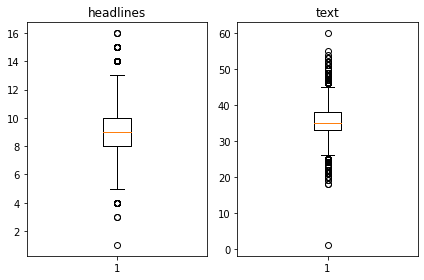

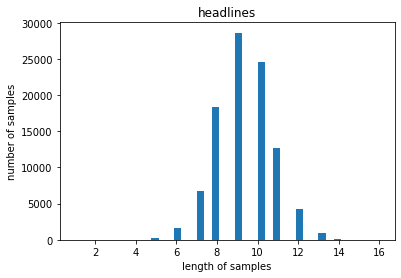

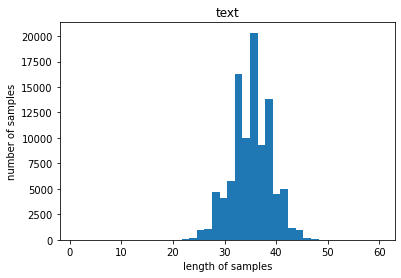

In [14]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
text_max_len = 45
summary_max_len = 13

In [16]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [17]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len, data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


In [18]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플 수 :',(len(data)))

전체 샘플 수 : 97863


### 시작 토큰과 종료 토큰 추가

In [19]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [20]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [21]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[50981 51522 62401 ... 10120 90003 17937]


In [22]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [23]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19572


In [24]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :',len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


## 4. 정수 인코딩

### 단어 집합(vocabulary) 생성, 정수 인코딩

In [25]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [26]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69295
등장 빈도가 6번 이하인 희귀 단어의 수: 47175
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22120
단어 집합에서 희귀 단어의 비율: 68.07850494263656
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4941101907904804


In [27]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [28]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[3316, 36, 274, 4114, 1384, 3463, 274, 65, 3084, 98, 196, 1247, 759, 2201, 285, 274, 1194, 107, 3478, 107, 897, 2201, 5970, 162, 343, 8644, 274, 908, 274, 1001, 188, 284, 1001], [517, 4153, 2655, 203, 212, 91, 630, 10012, 73, 61, 1385, 7, 11, 316, 212, 1551, 589, 73, 2, 73, 510, 7, 630, 2655, 212, 7, 73, 2498, 4115, 2541, 317, 1975, 212, 1551, 73], [236, 679, 71, 1, 1868, 3, 1164, 51, 3006, 8934, 3501, 76, 1239, 23, 398, 16665, 8934, 759, 792, 6237, 27, 4058, 10445, 3437, 719, 2214, 4, 4598, 1, 2920, 528]]


In [29]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [30]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30005
등장 빈도가 5번 이하인 희귀 단어의 수: 19611
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10394
단어 집합에서 희귀 단어의 비율: 65.35910681553074
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.661175822074784


In [31]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 37, 3329, 273, 3582, 127, 249, 434, 1892, 19, 847, 137], [1, 1508, 44, 30, 3, 21, 225, 52, 1545, 4, 89], [1, 251, 62, 5, 2069, 202, 3, 2909, 5619, 781, 71, 310], [1, 9, 546, 764, 28, 241, 3330, 42, 3173], [1, 1486, 1166, 7, 854, 6, 2425, 550]]
target
decoder  [[37, 3329, 273, 3582, 127, 249, 434, 1892, 19, 847, 137, 2], [1508, 44, 30, 3, 21, 225, 52, 1545, 4, 89, 2], [251, 62, 5, 2069, 202, 3, 2909, 5619, 781, 71, 310, 2], [9, 546, 764, 28, 241, 3330, 42, 3173, 2], [1486, 1166, 7, 854, 6, 2425, 550, 2]]


In [32]:
# 요약문의 길이가 1인 경우 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :',len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### 패딩

In [33]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

## 5. 모델 설계하기

### seq2seq

In [34]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [35]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

### 어텐션 메커니즘

In [36]:
# 어텐션 함수 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [37]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 6. 모델 훈련하기

In [38]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 512, callbacks=[es], epochs = 50)

Epoch 1/50
153/153 [==============================] - 173s 1s/step - loss: 5.9010 - val_loss: 5.0188
Epoch 2/50
153/153 [==============================] - 161s 1s/step - loss: 4.9900 - val_loss: 4.7506
Epoch 3/50
153/153 [==============================] - 161s 1s/step - loss: 4.7187 - val_loss: 4.4920
Epoch 4/50
153/153 [==============================] - 159s 1s/step - loss: 4.4275 - val_loss: 4.2439
Epoch 5/50
153/153 [==============================] - 159s 1s/step - loss: 4.1800 - val_loss: 4.0902
Epoch 6/50
153/153 [==============================] - 158s 1s/step - loss: 3.9945 - val_loss: 3.9676
Epoch 7/50
153/153 [==============================] - 157s 1s/step - loss: 3.8414 - val_loss: 3.8695
Epoch 8/50
153/153 [==============================] - 156s 1s/step - loss: 3.7001 - val_loss: 3.7889
Epoch 9/50
153/153 [==============================] - 157s 1s/step - loss: 3.5832 - val_loss: 3.7181
Epoch 10/50
153/153 [==============================] - 156s 1s/step - loss: 3.4786 - val_lo

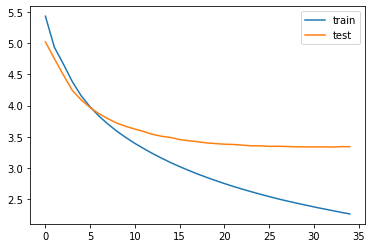

In [39]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 7. 모델 테스트하기

### 인퍼런스 모델 구현

In [40]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [41]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [42]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [43]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 실제 결과와 요약문 비교하기 (추상적 요약)

In [44]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [45]:
# 실제 요약과 예측된 요약 비교
for i in range(10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : united nations general assembly session indian diplomats reiterated kashmir integral part india amount empty rhetoric pakistan change reality remarks came reply pakistan accusation people kashmir victims killings mass 
실제 요약 : pak empty cannot change fact kashmir ours india 
예측 요약 :  un envoy to un haley over remarks on un haley


원문 : year old malaysian man arrested hours wedding reception allegedly getting scuffle police officers trying arrest one guests man allegedly threw glass police officers injured one meanwhile wanted man accused involved several crimes managed escape 
실제 요약 : man spends night in jail hours after getting married 
예측 요약 :  man arrested for trying to fight acid attack on wedding


원문 : pakistan largest tv network geo news allowed back air agreed show military positive light officials working channel said channel also directed stop favourable coverage corruption accused ex pm nawaz sharif geo news blocked country criticism military 
실제 요약 : pak tv network bac

## 8. Summa을 이용해서 추출적 요약해보기

In [46]:
from summa.summarizer import summarize
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [47]:
data['summary'] = data['text'].apply(lambda x: summarize(x, ratio=0.5))

In [48]:
data.sample(10)

,headlines,text,summary
54407,Rajinikanth confirms new release date of his f...,Rajinikanth has confirmed the new release date...,Rajinikanth has confirmed the new release date...
61821,You exploit me: SRK to Farah on 10 years of 'O...,"Filmmaker Farah Khan, on the occasion of 'Om S...","Filmmaker Farah Khan, on the occasion of 'Om S..."
15724,Musk-backed startup Stripe raises $245mn at $...,Billionaire Elon Musk-backed digital payments ...,Billionaire Elon Musk-backed digital payments ...
18730,Nearly 90 elephants killed for ivory in Botswana,The bodies of 87 elephants have been found nea...,"Notably, Botswana has the world's largest elep..."
71149,Stuart Binny gets interviewed by wife Mayanti ...,Indian cricketer Stuart Binny was interviewed ...,Indian cricketer Stuart Binny was interviewed ...
80140,"SBI Life Insurance files for IPO, to raise ove...","SBI Life Insurance, a unit of State Bank of In...",SBI Life will be the second Indian life insure...
86461,Dancing groom drops dead minutes before marria...,A groom died after suffering a massive heart a...,A groom died after suffering a massive heart a...
89312,Ocean plastic cleanup to start 2 years ahead o...,"The Ocean Cleanup, a Dutch foundation developi...","The Ocean Cleanup, a Dutch foundation developi..."
59893,US prosecutors charge Iranian with Game of Thr...,US prosecutors have charged an Iranian nationa...,US prosecutors have charged an Iranian nationa...
18110,UK teen jailed for Indian-origin man's murder ...,A 16-year-old boy has been sentenced to four y...,"The boy attacked Vijaykumar Patel, who had ref..."


In [49]:
# 실제 요약과 추출된 요약 비교
for i in range(10):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("추출 요약 :", data['summary'][i])
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출 요약 : Users get one CRED coin per rupee of bill pai

# 프로젝트 결과

- summa.summarizer을 사용하여 추출적 요약을 해보고 어텐션 메커니즘을 사용한 seq2seq을 이용하여 추상적 요약도 해보았는데 추상적 요약의 경우는 [군과 협의 후 다시 방송하는 pak TV 방송]과 [파키스탄, TV쇼 단속 속에 언론 폐쇄] 같이 의미가 아예 다르게 잘못된 요약도 많아 보이고 그냥 내용과 상관없는 요약도 종종 보이는데 추출적 요약은 원문에서 그대로 가져오므로 문장이 길어지는 현상을 보이는 것 같고 이것도 잘못된 요약이 많지만 그래도 추상적 요약보다는 더 의미가 원래에 가깝게 요약되는 경향이 있어 보인다.
- 추상적 요약은 아무래도 문장을 다시 만들어내는 것이기 때문에 표현력은 추출적 요약보다는 높겠지만 실제로 문장을 잘 요약하기 위해 많은 학습시간과 데이터가 필요해 보인다. 맞는지 모르겠지만 개인적인 생각으로는 early stopping을 이용했는데도 로스값이 높은 걸 보면 단순히 텍스트 정제 방법, 문장 최대 길이, Vocabulary 크기, 모델 구조 등을 변경하는 것으로 성능을 향상시키는데에는 한계가 있지 않을까 싶다.
- 개인적으로 느끼기에 자연어 처리분야는 개념이 복잡하고 원하는 모델을 실제로 구현하기도 어려운 분야라는 생각이 든다. 긴 코드에 비해 결과물은 너무 허접했고 그 원인이 바로 적은 자원과 시간을 투자했기 때문이 아닐까 생각한다. 네이버나 구글같은 대기업에서는 엄청난 컴퓨팅 자원과 데이터를 바탕으로 자연어 처리를 서비스를 구현하기 때문에 지금의 구글 번역기와 파파고 같은 퀄리티 높은 번역서비스를 운영하겠지만 우리가 할 수 있는 작은 데이터셋과 컴퓨팅 자원으로는 퀄리티 높은 자연어 처리를 할 수 있을지 의문이다.